Formulation of a mixed sensitivity $H_\infty$ problem as the standard problem by suitably defining the augmented plant $G$ in the LFT. The problem is equivalent to design 3 in Hinfinity_mixed_sensitivity

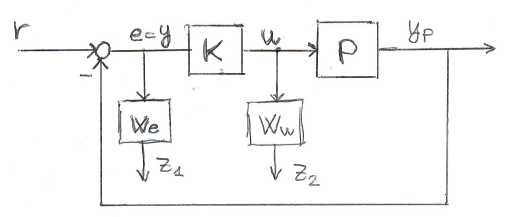
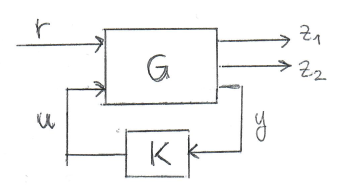

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import rpc_diism.robust as rb
s = ct.tf('s')

In [2]:
# Plant definition
den = [0.2, 1.2, 1]
P = ct.tf([[[1], [1]],
              [[2, 1], [2]]],
             [[den, den],
              [den, den]])

display("Plant transfer function", P)

# Weight on error
M = 1.5
e = 1e-4
wb = 0.25 # Crossover frequency
We11 = ct.ss(rb.weightS(wb, M, e, 1))
We = ct.tf(We11.append(We11)) # Block diagonal combination of We with itself

# Weight on command input
Mu = 1.5
eu = 1e-4
wbc = 10 
Wu11 = ct.ss(rb.weightU(wbc, Mu, eu, 1))
Wu = ct.tf(Wu11.append(Wu11))

'Plant transfer function'

TransferFunction(
[[array([1]), array([1])],
 [array([2, 1]), array([2])]],
[[array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])],
 [array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])]],
outputs=2, inputs=2)

Generate the G block in the LFT corresponding to the given design using system interconnection functions.

In [3]:
# Define labels for system inputs and outputs in each block of the control loop
P.input_labels = ['u[0]','u[1]']
P.output_labels = ['yp[0]','yp[1]']
We.input_labels = ['y[0]','y[1]']
We.output_labels = ['z[0]','z[1]']
Wu.input_labels = ['u[0]','u[1]']
Wu.output_labels = ['z[2]','z[3]'] 

# Negative feedback summing junction: y = r-v
fbk = ct.summing_junction(inputs=['r','-yp'], output=['y'], dimension=2)

# Generate the G transfer function of the LFT by interconnecting all blocks
G = ct.interconnect([P, We, Wu, fbk],
                    inputs=['r[0]','r[1]','u[0]','u[1]'],
                    outputs=['z[0]','z[1]','z[2]','z[3]','y[0]','y[1]'])


Solve the $H_\infty$ problem for the generated LFT

In [4]:
K, Tzw, gamma, rcond = rb.hinfsyn(G, nmeas=2, ncon=2)
display("gamma:", gamma)

'gamma:'

2.044310441632442

Do singular value plot of the obtained closed loop sensitivities

Text(0.5, 1.0, 'Singular values of S vs. gamma*inv(We)')

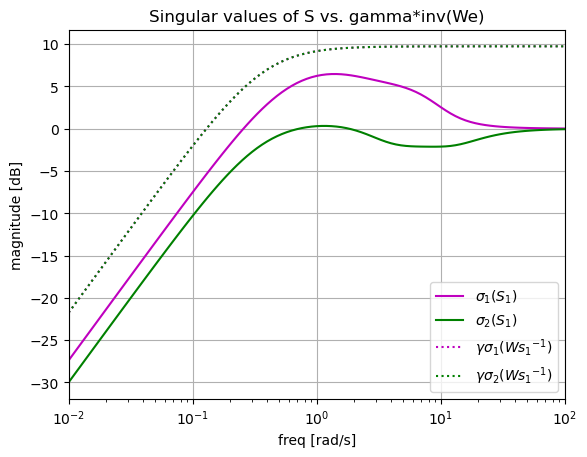

In [5]:
# Frequency range
w = np.logspace(-2, 2, 101)

# Compute sensitivity
I = ct.ss([], [], [], np.eye(2)) # Identity system
S = ct.feedback(I,P*K)

# Compute singular values of S
Ssv = rb.sigma(S, w)

# Compute singular values of gamma*inv(We)
Weinv = rb.invss(ct.ss(We))
Weinvsv = rb.sigma(Weinv, w) * gamma

plt.semilogx(w, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S_1)$')
plt.semilogx(w, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({Ws_1}^{-1})$')
plt.semilogx(w, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({Ws_1}^{-1})$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. gamma*inv(We)')


Text(0.5, 1.0, 'Singular values of KS vs. gamma*inv(Wu)')

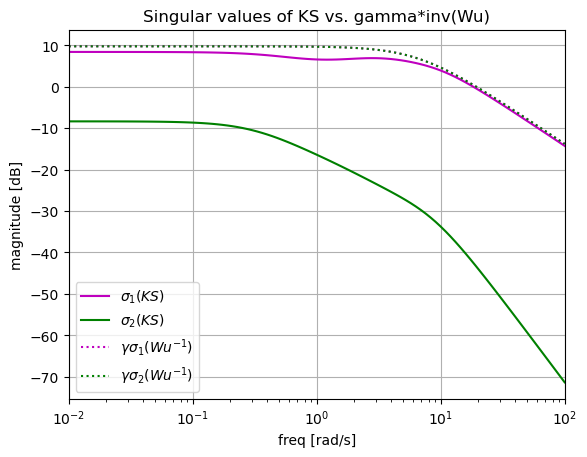

In [6]:
# Compute input sensitivity
KS = K*S

# Compute singular values of KS
KSsv = rb.sigma(KS, w)

# Compute singular values of gamma*inv(Wu)
Wuinv = rb.invss(ct.ss(Wu))
Wuinvsv = rb.sigma(Wuinv, w) * gamma

plt.semilogx(w, 20*np.log10(KSsv[:, 0]), 'm', label=r'$\sigma_1(KS)$')
plt.semilogx(w, 20*np.log10(KSsv[:, 1]), 'g', label=r'$\sigma_2(KS)$')
plt.semilogx(w, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({Wu}^{-1})$')
plt.semilogx(w, 20*np.log10(Wuinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({Wu}^{-1})$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS vs. gamma*inv(Wu)')